# Summary

-----

# Imports

In [1]:
%run imports.ipynb

2016-09-20 23:35:55.826228


In [2]:
NOTEBOOK_NAME = 'data_statistics'
os.environ['NOTEBOOK_NAME'] = NOTEBOOK_NAME

In [3]:
CORE_OR_INTERFACE = 1

# Parameters

In [4]:
# Set CORE parameters
if CORE_OR_INTERFACE in [0, 'core']:
    COI_SUFFIX = '_CORE'
    TRAINING_DATASET_NAME = 'protherm++'
    DATA_DF = pd.read_pickle(op.join('load_data', 'DATA_DF_TT_CORE.pkl'))
    FEATURE_COLUMNS = elaspic.elaspic_predictor.FEATURE_COLUMNS_CORE[:]
    DATASETS = [
        'protherm',
        'protherm_star',
        'taipale',        
        'humsavar',
        'clinvar',
        'cosmic',
        # Interface
        'kortemme_baker',
        'skempi',
        'taipale_gpca',
        'taipale_ppi',
        # Other
        'cagi4_sumo_ligase',
        'ab_bind',
        'benedix_et_al',
        'hiv_escape_mutations',
    ]

In [5]:
# Set INTERFACE parameters
if CORE_OR_INTERFACE in [1, 'interface']:
    COI_SUFFIX = '_INTERFACE'
    TRAINING_DATASET_NAME = 'skempi++'
    DATA_DF = pd.read_pickle(op.join('load_data', 'DATA_DF_TT_INTERFACE.pkl'))
    FEATURE_COLUMNS = elaspic.elaspic_predictor.FEATURE_COLUMNS_INTERFACE[:]
    DATASETS = [
        'kortemme_baker',
        'skempi',
        'taipale',
        'taipale_gpca',
        'taipale_ppi',
        'humsavar',
        'clinvar',
        'cosmic',
        'cagi4_sumo_ligase',
        'ab_bind',
        'benedix_et_al',
        'hiv_escape_mutations',
    ]

# Load data

In [6]:
db_remote = datapkg.MySQLConnection(
    os.environ['DATAPKG_CONNECTION_STRING'], 
    NOTEBOOK_NAME, 
    None, 
    echo=False)

## Load DATA

This includes both calculated (with $\Delta \Delta G$ prediction) and not calculated (without $\Delta \Delta G$ prediction).

In [7]:
with open('load_data/DATA_STANDALONE{}.pkl'.format(COI_SUFFIX), 'rb') as ifh:
    DATA_STANDALONE = pickle.load(ifh)

In [8]:
for key in DATA_STANDALONE:
    DATA_STANDALONE[key] = kmtools.df_tools.remove_duplicate_columns(DATA_STANDALONE[key])

In [9]:
with open('load_data/DATA_DATABASE{}.pkl'.format(COI_SUFFIX), 'rb') as ifh:
    DATA_DATABASE = pickle.load(ifh)

In [10]:
# dataset_map = {
#     'protherm': 'protherm++',
#     'protherm_star': 'protherm++',
# }

DATA = {}
for key in (set(DATA_STANDALONE.keys()) | set(DATA_DATABASE.keys())):
    l = []
    if key in DATA_STANDALONE:
        l.append(DATA_STANDALONE[key])
    if key in DATA_DATABASE:
        l.append(DATA_DATABASE[key])
    # DATA[dataset_map.get(key, key)] = pd.concat(l)
    DATA[key] = pd.concat(l)

In [11]:
for column in ['hiv_escape_mutations', 'benedix_et_al']:
    if column in DATA:
        DATA[column]['ddg_exp'] = DATA[column]['ddg_exp']

## Load DATA_DF

This only includes calculated mutations (with $\Delta \Delta G$ prediction).

In [12]:
DATA_DF = pd.read_pickle('load_data/DATA_DF{}.pkl'.format(COI_SUFFIX))
#DATA_DF['ddg_exp'] = DATA_DF['ddg_exp'].astype(float)

In [13]:
# Reverse the ddg_exp sign for some datasets
DATA_DF.loc[
    DATA_DF['dataset'].isin(['hiv_escape_mutations', 'benedix_et_al']),
    'ddg_exp'
] = (
    -DATA_DF.loc[
        DATA_DF['dataset'].isin(['hiv_escape_mutations', 'benedix_et_al']),
        'ddg_exp'
    ]
)

## Load DATA_DF_TT

In [14]:
DATA_DF_TT = pd.read_pickle('load_data/DATA_DF_TT{}.pkl'.format(COI_SUFFIX))
#DATA_DF['ddg_exp'] = DATA_DF['ddg_exp'].astype(float)

In [15]:
# Reverse the ddg_exp sign for some datasets
DATA_DF_TT.loc[
    DATA_DF_TT['dataset'].isin(['hiv_escape_mutations', 'benedix_et_al']),
    'ddg_exp'
] = (
    -DATA_DF_TT.loc[
        DATA_DF_TT['dataset'].isin(['hiv_escape_mutations', 'benedix_et_al']),
        'ddg_exp'
    ]
)

## Compare

In [16]:
DATA_DATABASE['cosmic'][['uniprot_id', 'uniprot_mutation']].drop_duplicates().shape[0]
# 357,980 / 

26913

In [17]:
DATA_DF[DATA_DF['dataset'] == 'cosmic'][['uniprot_id', 'mutation']].drop_duplicates().shape[0]
# 357,980 / 

26913

In [18]:
pd.concat([
    DATA_DF_TT[DATA_DF_TT['dataset'] == 'cosmic_train'][['uniprot_id', 'mutation']],
    DATA_DF_TT[DATA_DF_TT['dataset'] == 'cosmic_test'][['uniprot_id', 'mutation']]
]).drop_duplicates().shape[0]
# 357,980 / 

26913

# -----------------------------------------

# DATA

## Parameters

In [19]:
DATA.keys()

dict_keys(['ab_bind', 'clinvar', 'hiv_escape_mutations', 'taipale', 'kortemme_baker', 'benedix_et_al', 'humsavar', 'skempi', 'taipale_gpca', 'cosmic', 'taipale_ppi', 'cagi4_sumo_ligase'])

In [20]:
assert not set(DATA.keys()) ^ set(DATASETS)

In [21]:
assert not set(DATA.keys()) ^ set(DATASETS)

## Dataset overlap

In [22]:
def get_unique_id(df):
    _df = df[['uniprot_id', 'uniprot_mutation']].dropna()
    uniprot_mutation_set = set(_df['uniprot_id'].astype(str) + '.' + _df['uniprot_mutation'].astype(str))
    
    try:
        _df = df[['pdb_id', 'pdb_mutation']].dropna()
        pdb_mutation_set = set(_df['pdb_id'].astype(str) + '.' + _df['pdb_mutation'].astype(str))
    except KeyError:
        pdb_mutation_set = set()

    return uniprot_mutation_set, pdb_mutation_set

In [23]:
counts = {}
df = DATA_DF.dropna(subset=['ddg']).copy()
df_out = pd.DataFrame(columns=DATASETS, index=DATASETS, dtype=float)

for dataset_1 in DATASETS:
    print(dataset_1)
    df_1 = DATA[dataset_1].copy()
    if df_1.empty:
        print(dataset_1)
    uniprot_mutation_set_1, pdb_mutation_set_1 = get_unique_id(df_1)
    counts[dataset_1] = max([len(uniprot_mutation_set_1), len(pdb_mutation_set_1)])
    for dataset_2 in DATASETS:
        # print('\t', dataset_2)
        df_2 = DATA[dataset_2].copy()
        if df_2.empty:
            print(dataset_2)
        uniprot_mutation_set_2, pdb_mutation_set_2 = get_unique_id(df_2)
        if uniprot_mutation_set_1:
            uniprot_frac_covered = (
                1 - len(uniprot_mutation_set_1 - uniprot_mutation_set_2) / len(uniprot_mutation_set_1))
        else:
            uniprot_frac_covered = 0
        if pdb_mutation_set_1:
            pdb_frac_covered = (
                1 - len(pdb_mutation_set_1 - pdb_mutation_set_2) / len(pdb_mutation_set_1))
        else:
            pdb_frac_covered = 0
        df_out.loc[dataset_1, dataset_2] = max([uniprot_frac_covered, pdb_frac_covered]) * 100.0
df_out.index = ['{}\n(n = {:,.0f})'.format(x, counts[x]) for x in df_out.index]

kortemme_baker
skempi
taipale
taipale_gpca
taipale_ppi
humsavar
clinvar
cosmic
cagi4_sumo_ligase
ab_bind
benedix_et_al
hiv_escape_mutations


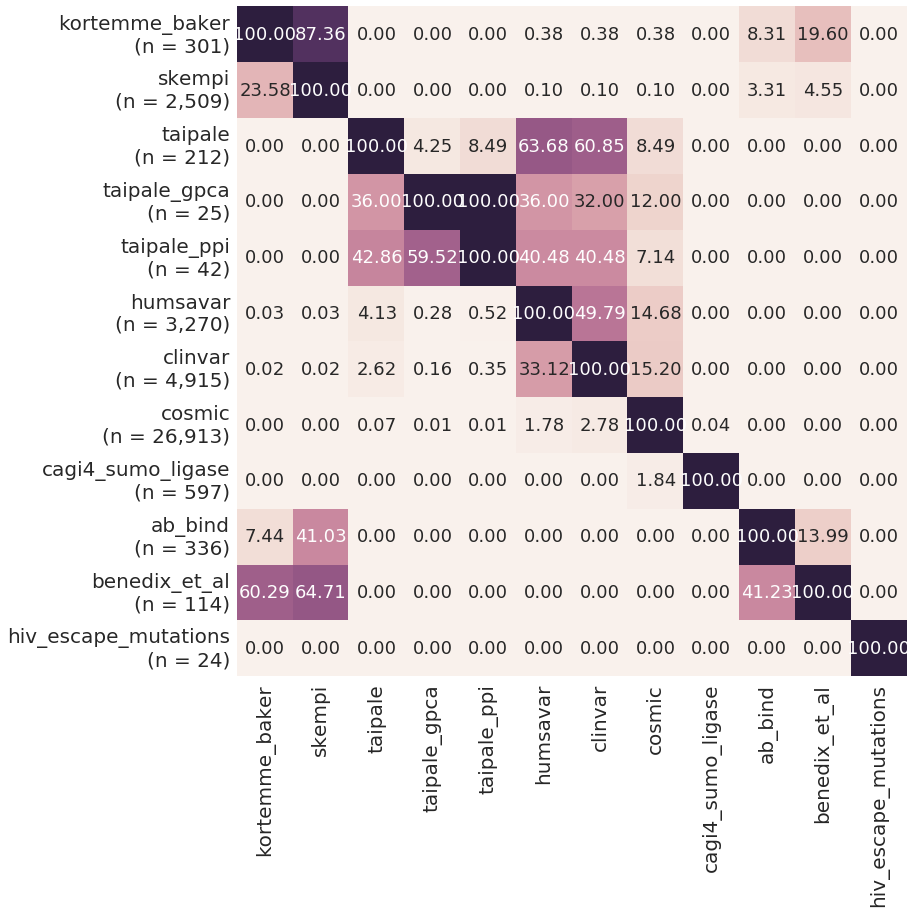

In [24]:
fg, ax = plt.subplots(figsize=(16, 12))
sns.heatmap(df_out, annot=True, fmt=".2f", ax=ax, square=True, cbar=False, annot_kws={"size": 18})
plt.yticks(rotation='horizontal')
plt.savefig(
    op.join(NOTEBOOK_NAME, 'training_set_overlap_data{}.png'.format(COI_SUFFIX.lower())), 
    bbox_inches='tight', dpi=220)
plt.savefig(
    op.join(NOTEBOOK_NAME, 'training_set_overlap_data{}.pdf'.format(COI_SUFFIX.lower())),
    bbox_inches='tight')

## Correlations

/home/kimlab1/strokach/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


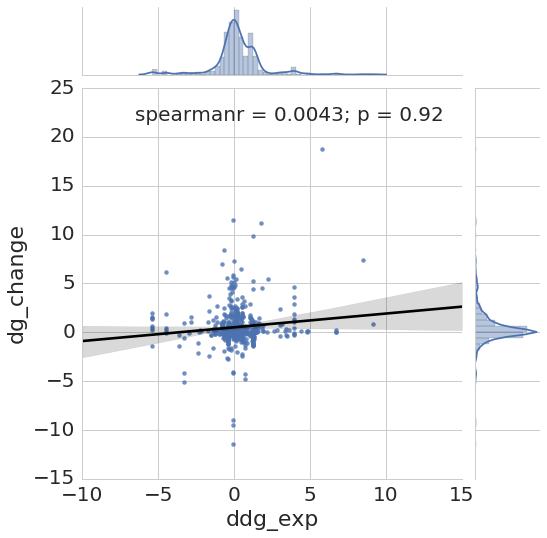

In [25]:
# Some validation to make sure that we 
ax = sns.jointplot(
    x='ddg_exp', 
    y='dg_change',
    data=DATA['taipale'][['ddg_exp', 'dg_change']].drop_duplicates(), 
    stat_func=sp.stats.spearmanr,
    kind="reg",
    size=8,
    line_kws={'color': 'k'},
)

### Correlation with Foldx

kortemme_baker
skempi
taipale
taipale_gpca
taipale_ppi
humsavar
clinvar
cosmic
cagi4_sumo_ligase
ab_bind
benedix_et_al
hiv_escape_mutations


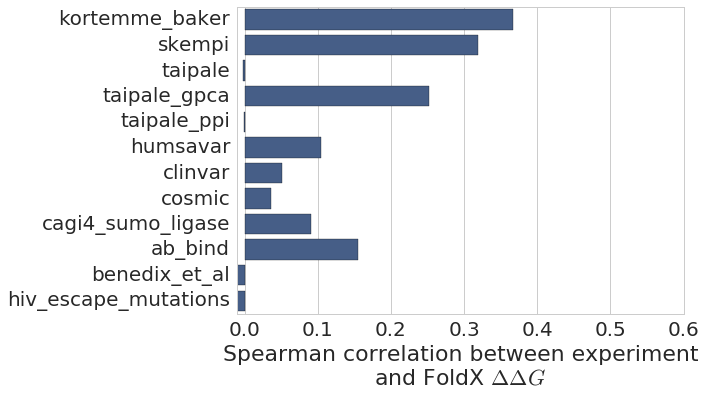

In [26]:
corrs = OrderedDict()
for table_name in DATASETS:
    print(table_name)
    df = DATA[table_name].drop_duplicates()
    if table_name in ['humsavar', 'clinvar', 'cosmic']:
        df['ddg_exp'] = df['del_class_exp']
    elif table_name in ['cagi4_sumo_ligase']:
        df['ddg_exp'] = -df['del_score_exp']
    
    df = df.dropna(subset=['dg_change', 'ddg_exp'])
    corrs[table_name] = sp.stats.spearmanr(df['dg_change'], df['ddg_exp'])[0]
corrs = pd.Series(corrs)

fg, ax = plt.subplots()
x = sns.barplot(corrs.values, corrs.index, ax=ax, color=sns.xkcd_rgb["denim blue"])
plt.xlim(-0.01, 0.6)
ax.set_xlabel('Spearman correlation between experiment\nand FoldX $\Delta \Delta G$')

### Correlation with Provean

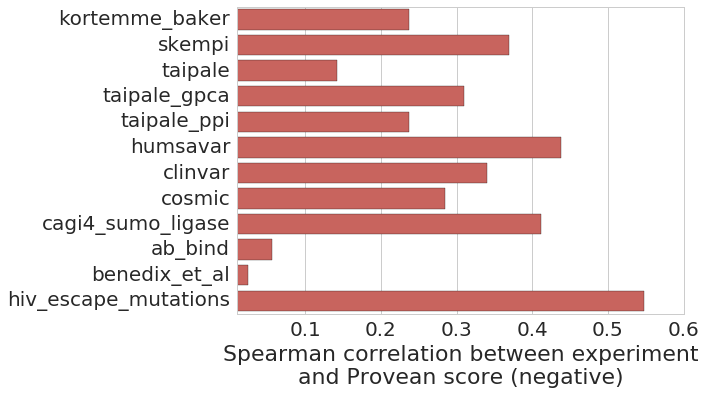

In [27]:
corrs = OrderedDict()
for table_name in DATASETS:
    df = DATA[table_name].drop_duplicates()
    if table_name in ['humsavar', 'clinvar', 'cosmic']:
        df['ddg_exp'] = df['del_class_exp']
    elif table_name in ['cagi4_sumo_ligase']:
        df['ddg_exp'] = -df['del_score_exp']
    df = df.dropna(subset=['provean_score', 'ddg_exp'])
    if table_name in ['benedix_et_al', 'hiv_escape_mutations']:
        corrs[table_name] = sp.stats.spearmanr(df['provean_score'], df['ddg_exp'])[0]
    else:
        corrs[table_name] = -sp.stats.spearmanr(df['provean_score'], df['ddg_exp'])[0]
corrs = pd.Series(corrs)

fg, ax = plt.subplots()
x = sns.barplot(corrs.values, corrs.index, ax=ax, color=sns.xkcd_rgb["pale red"])
plt.xlim(0.01, 0.6)
ax.set_xlabel('Spearman correlation between experiment\nand Provean score (negative)')

# DATA_DF

## Parameters

In [28]:
DATA_DF.head()

,_index,alignment_coverage,alignment_filename_1,alignment_filename_2,alignment_identity,alignment_score,analyse_complex_energy_mut,analyse_complex_energy_wt,backbone_clash_change,backbone_clash_wt,backbone_hbond_change,backbone_hbond_wt,cath_id_1,cath_id_2,chain_1,chain_2,chain_modeller,cis_bond_change,cis_bond_wt,conserved_1,conserved_2,conserved_if_1,conserved_if_2,contact_distance_change,contact_distance_wt,coverage_1,coverage_2,coverage_if_1,coverage_if_2,dataset,db,ddg,ddg_exp,del_class_exp,del_score_exp,dg_change,dg_wt,disulfide_change,disulfide_wt,domain_contact_id,domain_contact_ids,electrostatic_kon_change,electrostatic_kon_wt,electrostatics_change,electrostatics_wt,energy_ionisation_change,energy_ionisation_wt,entropy_complex_change,entropy_complex_wt,entropy_mainchain_change,entropy_mainchain_wt,entropy_sidechain_change,entropy_sidechain_wt,gene_name,helix_dipole_change,helix_dipole_wt,id,identical_1,identical_2,identical_if_1,identical_if_2,idx,idxs,interacting_aa_1,interacting_aa_2,interface_area_hydrophilic,interface_area_hydrophobic,interface_area_total,interface_dg,intraclashes_energy_1_change,intraclashes_energy_1_wt,intraclashes_energy_2_change,intraclashes_energy_2_wt,m_date_modified,matrix_score,max_seq_identity,mloop_entropy_change,mloop_entropy_wt,model_domain_def_1,model_domain_def_2,model_errors,model_file_mut,model_file_wt,model_filename,model_filename_mut,model_filename_wt,mut_date_modified,mutation,mutation_errors,mutation_modeller,norm_dope,number_of_residues,organism_name,partial_covalent_bonds_change,partial_covalent_bonds_wt,partner_pdb_chain,partner_uniprot_id,path_to_data,pcv_hbond_change,pcv_hbond_self_change,pcv_hbond_self_wt,pcv_hbond_wt,pcv_salt_equal_change,pcv_salt_equal_self_change,pcv_salt_equal_self_wt,pcv_salt_equal_wt,pcv_salt_opposite_change,pcv_salt_opposite_self_change,pcv_salt_opposite_self_wt,pcv_salt_opposite_wt,pcv_vdw_change,pcv_vdw_self_change,pcv_vdw_self_wt,pcv_vdw_wt,pdb_chain,pdb_id,pdb_mutation,pfam_clan,pfam_id,protein_existence,protein_name,provean_score,rigids,score_1,score_2,score_if_1,score_if_2,score_if_total,score_overall,score_total,secondary_structure_change,secondary_structure_wt,sequence_version,sidechain_hbond_change,sidechain_hbond_wt,sloop_entropy_change,sloop_entropy_wt,solvation_hydrophobic_change,solvation_hydrophobic_wt,solvation_polar_change,solvation_polar_wt,solvent_accessibility_change,solvent_accessibility_wt,stability_energy_mut,stability_energy_wt,t_date_modified,template_errors,torsional_clash_change,torsional_clash_wt,uniprot_domain_id_1,uniprot_domain_id_2,uniprot_domain_pair_id,uniprot_domain_pair_id_old,uniprot_id,uniprot_id_1,uniprot_id_2,uniprot_mutation,uniprot_name,uniprot_sequence,van_der_waals_change,van_der_waals_clashes_change,van_der_waals_clashes_wt,van_der_waals_wt,water_bridge_change,water_bridge_wt
0,1.0,1.0,NaN,NaN,1.0,1.0,NaN,NaN,-0.41394,2.28539,0.39852,-2.96249,NaN,NaN,NaN,NaN,C,0.0,0.000000,NaN,NaN,NaN,NaN,0.669686,2.316060,NaN,NaN,NaN,NaN,ab_bind,NaN,2.184765,1.300,NaN,NaN,-1.07761,-3.04699,0.0,0.000000e+00,NaN,NaN,0.076265,-0.345444,1.037007,-1.672890,0.0,5.551120e-17,0.0,2.384,0.29724,1.94618,-0.27158,3.74864,NaN,0.000000,-0.029492,NaN,NaN,NaN,NaN,NaN,2.0,"[1, 2]",NaN,NaN,893.155,163.970,1057.125,NaN,-0.6693,35.0678,-0.0071,70.8110,NaT,-2.0,100.0,0.0,0.0,NaN,NaN,NaN,/home/kimlab1/database_data/biodb/recipes/elas...,/home/kimlab1/database_data/biodb/recipes/elas...,NaN,NaN,NaN,NaT,D101A,,D311A,-0.729193,339.0,NaN,0.0,0.0,HL,None,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-6.0,0.0,17.0,24.0,C,1dqj,C_D101A,NaN,None,NaN,NaN,-6.468,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,7.0,NaN,1.24830,-6.04260,0.0,0.0,0.50410,-11.6149,-3.0277,15.8298,-7.747875,62.562789,"102.731,-206.699,-100.172,-378.594,-7.52855,50...","103.827,-207.978,-102.375,-379.722,-8.7808,510...",NaN,NaN,-0.034182,0.928992,NaN,NaN,NaN,NaN,None,NaN,NaN,None,NaN,NaN,0.86557,-2.17121,4.97405,-10.19080,0.0,0.0
1,2.0,1.0,NaN,NaN,1.0,1.0,NaN,NaN,-0.00118,2.71165,0.00

In [29]:
if CORE_OR_INTERFACE in [0, 'core']:
    datasets = [
        'protherm++',
        'taipale',
        #
        'humsavar_train',
        'clinvar_train',
        'cosmic_train',
        #
        'humsavar_test',
        'clinvar_test',
        'cosmic_test',
        #
        'cagi4_sumo_ligase',
    ]

In [30]:
if CORE_OR_INTERFACE in [1, 'interface']:
    datasets = [
        'skempi++',
        'taipale',
        'taipale_ppi',
        'taipale_gpca',
        #
        'humsavar',
        'clinvar',
        'cosmic',
        #
        'cagi4_sumo_ligase',
        'hiv_escape_mutations',
        'benedix_et_al',
        'ab_bind',
    ]

kortemme_baker 0 0
skempi 0 1
taipale 0 2
taipale_gpca 1 0
taipale_ppi 1 1
humsavar 1 2
clinvar 2 0
cosmic 2 1
cagi4_sumo_ligase 2 2
ab_bind 3 0
benedix_et_al 3 1
hiv_escape_mutations 3 2


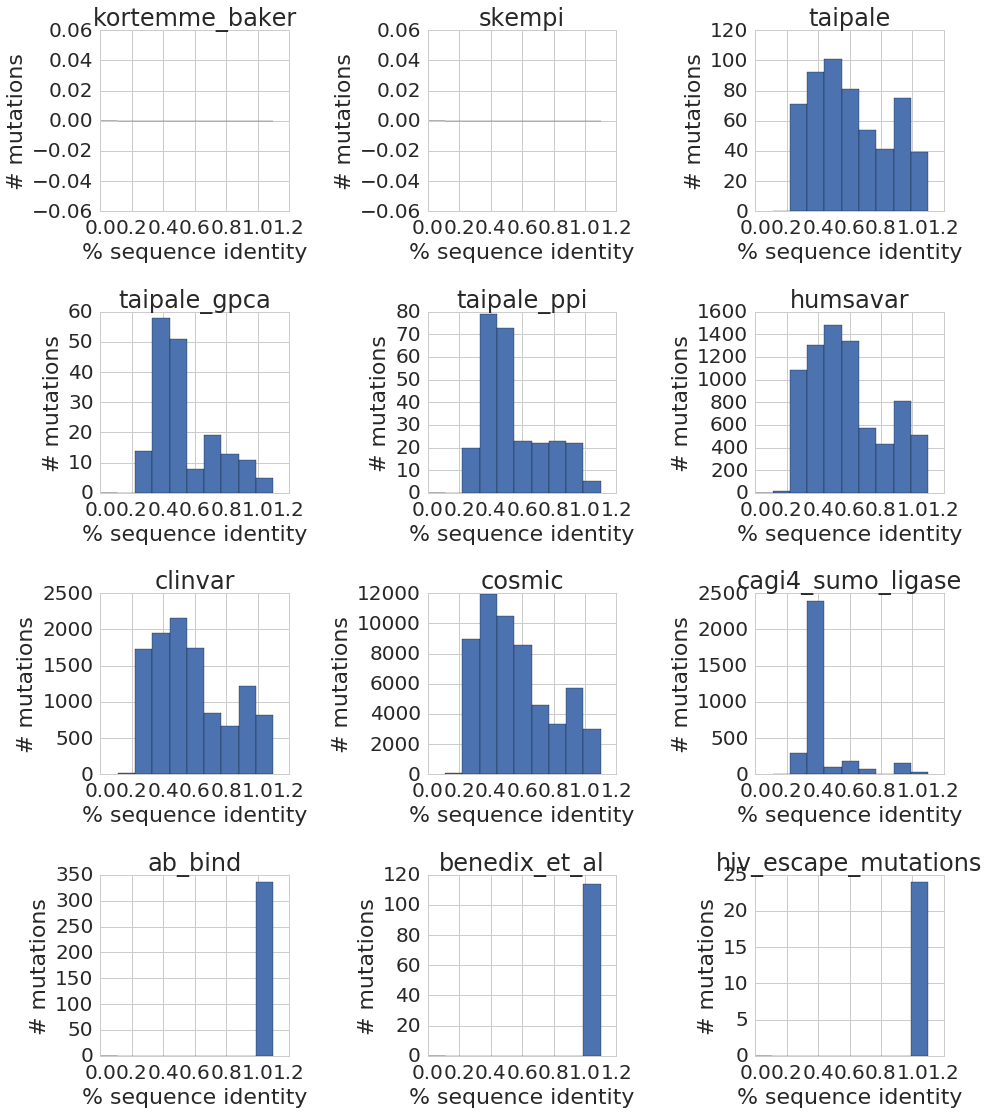

In [31]:
# Histogram sequence identities
fg, axes = plt.subplots(int(np.ceil(len(DATASETS) / 3)), 3, figsize=(14, 16))
for i, dataset in enumerate(DATASETS):
    p = i // 3
    q = i % 3
    print(dataset, p, q)
    ax = axes[p, q]
    DATA_DF[DATA_DF['dataset'] == dataset]['alignment_identity'].hist(range=(0, 1.1), bins=10, ax=ax)
    ax.set_title(dataset)
    ax.set_xlabel("% sequence identity")
    ax.set_ylabel("# mutations")
plt.tight_layout()

## Dataset overlap

In [32]:
def get_unique_id(df):
    _df = df[['uniprot_id', 'uniprot_mutation']].dropna()
    uniprot_mutation_set = set(_df['uniprot_id'].astype(str) + '.' + _df['uniprot_mutation'].astype(str))
    
    _df = df[['pdb_id', 'pdb_mutation']].dropna()
    pdb_mutation_set = set(_df['pdb_id'].astype(str) + '.' + _df['pdb_mutation'].astype(str))

    return uniprot_mutation_set, pdb_mutation_set

In [33]:
DATA_DF.head()

,_index,alignment_coverage,alignment_filename_1,alignment_filename_2,alignment_identity,alignment_score,analyse_complex_energy_mut,analyse_complex_energy_wt,backbone_clash_change,backbone_clash_wt,backbone_hbond_change,backbone_hbond_wt,cath_id_1,cath_id_2,chain_1,chain_2,chain_modeller,cis_bond_change,cis_bond_wt,conserved_1,conserved_2,conserved_if_1,conserved_if_2,contact_distance_change,contact_distance_wt,coverage_1,coverage_2,coverage_if_1,coverage_if_2,dataset,db,ddg,ddg_exp,del_class_exp,del_score_exp,dg_change,dg_wt,disulfide_change,disulfide_wt,domain_contact_id,domain_contact_ids,electrostatic_kon_change,electrostatic_kon_wt,electrostatics_change,electrostatics_wt,energy_ionisation_change,energy_ionisation_wt,entropy_complex_change,entropy_complex_wt,entropy_mainchain_change,entropy_mainchain_wt,entropy_sidechain_change,entropy_sidechain_wt,gene_name,helix_dipole_change,helix_dipole_wt,id,identical_1,identical_2,identical_if_1,identical_if_2,idx,idxs,interacting_aa_1,interacting_aa_2,interface_area_hydrophilic,interface_area_hydrophobic,interface_area_total,interface_dg,intraclashes_energy_1_change,intraclashes_energy_1_wt,intraclashes_energy_2_change,intraclashes_energy_2_wt,m_date_modified,matrix_score,max_seq_identity,mloop_entropy_change,mloop_entropy_wt,model_domain_def_1,model_domain_def_2,model_errors,model_file_mut,model_file_wt,model_filename,model_filename_mut,model_filename_wt,mut_date_modified,mutation,mutation_errors,mutation_modeller,norm_dope,number_of_residues,organism_name,partial_covalent_bonds_change,partial_covalent_bonds_wt,partner_pdb_chain,partner_uniprot_id,path_to_data,pcv_hbond_change,pcv_hbond_self_change,pcv_hbond_self_wt,pcv_hbond_wt,pcv_salt_equal_change,pcv_salt_equal_self_change,pcv_salt_equal_self_wt,pcv_salt_equal_wt,pcv_salt_opposite_change,pcv_salt_opposite_self_change,pcv_salt_opposite_self_wt,pcv_salt_opposite_wt,pcv_vdw_change,pcv_vdw_self_change,pcv_vdw_self_wt,pcv_vdw_wt,pdb_chain,pdb_id,pdb_mutation,pfam_clan,pfam_id,protein_existence,protein_name,provean_score,rigids,score_1,score_2,score_if_1,score_if_2,score_if_total,score_overall,score_total,secondary_structure_change,secondary_structure_wt,sequence_version,sidechain_hbond_change,sidechain_hbond_wt,sloop_entropy_change,sloop_entropy_wt,solvation_hydrophobic_change,solvation_hydrophobic_wt,solvation_polar_change,solvation_polar_wt,solvent_accessibility_change,solvent_accessibility_wt,stability_energy_mut,stability_energy_wt,t_date_modified,template_errors,torsional_clash_change,torsional_clash_wt,uniprot_domain_id_1,uniprot_domain_id_2,uniprot_domain_pair_id,uniprot_domain_pair_id_old,uniprot_id,uniprot_id_1,uniprot_id_2,uniprot_mutation,uniprot_name,uniprot_sequence,van_der_waals_change,van_der_waals_clashes_change,van_der_waals_clashes_wt,van_der_waals_wt,water_bridge_change,water_bridge_wt
0,1.0,1.0,NaN,NaN,1.0,1.0,NaN,NaN,-0.41394,2.28539,0.39852,-2.96249,NaN,NaN,NaN,NaN,C,0.0,0.000000,NaN,NaN,NaN,NaN,0.669686,2.316060,NaN,NaN,NaN,NaN,ab_bind,NaN,2.184765,1.300,NaN,NaN,-1.07761,-3.04699,0.0,0.000000e+00,NaN,NaN,0.076265,-0.345444,1.037007,-1.672890,0.0,5.551120e-17,0.0,2.384,0.29724,1.94618,-0.27158,3.74864,NaN,0.000000,-0.029492,NaN,NaN,NaN,NaN,NaN,2.0,"[1, 2]",NaN,NaN,893.155,163.970,1057.125,NaN,-0.6693,35.0678,-0.0071,70.8110,NaT,-2.0,100.0,0.0,0.0,NaN,NaN,NaN,/home/kimlab1/database_data/biodb/recipes/elas...,/home/kimlab1/database_data/biodb/recipes/elas...,NaN,NaN,NaN,NaT,D101A,,D311A,-0.729193,339.0,NaN,0.0,0.0,HL,None,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-6.0,0.0,17.0,24.0,C,1dqj,C_D101A,NaN,None,NaN,NaN,-6.468,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,7.0,NaN,1.24830,-6.04260,0.0,0.0,0.50410,-11.6149,-3.0277,15.8298,-7.747875,62.562789,"102.731,-206.699,-100.172,-378.594,-7.52855,50...","103.827,-207.978,-102.375,-379.722,-8.7808,510...",NaN,NaN,-0.034182,0.928992,NaN,NaN,NaN,NaN,None,NaN,NaN,None,NaN,NaN,0.86557,-2.17121,4.97405,-10.19080,0.0,0.0
1,2.0,1.0,NaN,NaN,1.0,1.0,NaN,NaN,-0.00118,2.71165,0.00

In [34]:
DATA_DF[DATA_DF['dataset'] == 'cosmic'].shape

(56654, 165)

In [35]:
counts = {}
df = DATA_DF.dropna(subset=['ddg']).copy()
df_out = pd.DataFrame(columns=DATASETS, index=DATASETS, dtype=float)

for dataset_1 in DATASETS:
    print(dataset_1)
    df_1 = df[df['dataset'] == dataset_1]
#     if df_1.empty:
#         print(dataset_1)
    uniprot_mutation_set_1, pdb_mutation_set_1 = get_unique_id(df_1)
    counts[dataset_1] = max([len(uniprot_mutation_set_1), len(pdb_mutation_set_1)])
    for dataset_2 in DATASETS:
        # print('\t', dataset_2)
        df_2 = df[df['dataset'] == dataset_2]
        # if df_2.empty:
            # print(dataset_2)
        uniprot_mutation_set_2, pdb_mutation_set_2 = get_unique_id(df_2)
        if uniprot_mutation_set_1:
            uniprot_frac_covered = (
                1 - len(uniprot_mutation_set_1 - uniprot_mutation_set_2) / len(uniprot_mutation_set_1))
        else:
            uniprot_frac_covered = 0
        if pdb_mutation_set_1:
            pdb_frac_covered = (
                1 - len(pdb_mutation_set_1 - pdb_mutation_set_2) / len(pdb_mutation_set_1))
        else:
            pdb_frac_covered = 0
        df_out.loc[dataset_1, dataset_2] = max([uniprot_frac_covered, pdb_frac_covered]) * 100.0
df_out.index = ['{}\n(n = {:,.0f})'.format(x, counts[x]) for x in df_out.index]

kortemme_baker
skempi
taipale
taipale_gpca
taipale_ppi
humsavar
clinvar
cosmic
cagi4_sumo_ligase
ab_bind
benedix_et_al
hiv_escape_mutations


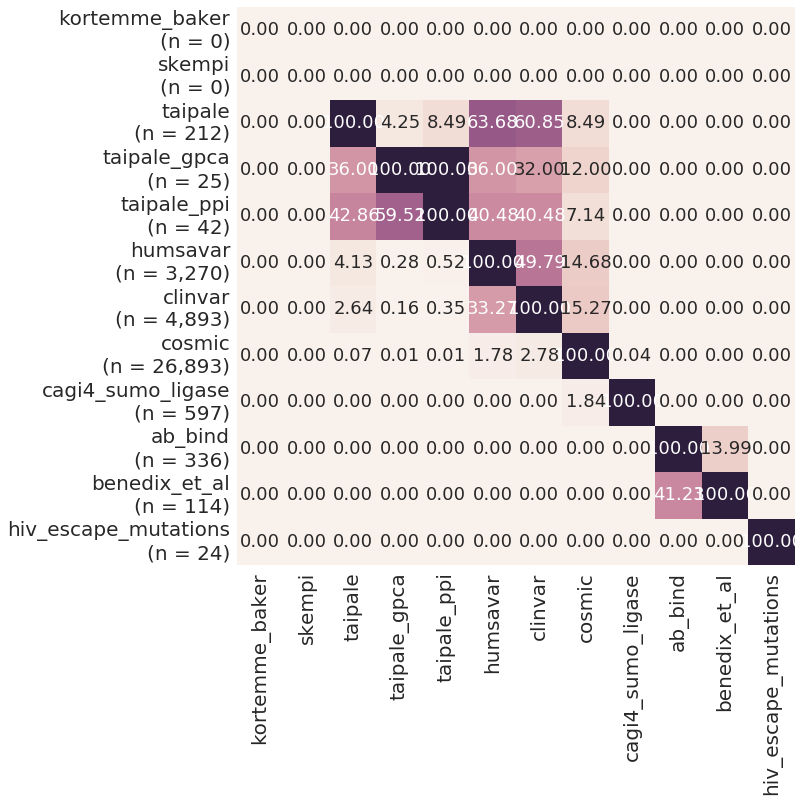

In [36]:
fg, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(df_out, annot=True, fmt=".2f", ax=ax, square=True, cbar=False, annot_kws={"size": 18})
plt.yticks(rotation='horizontal')
# plt.xticks(rotation=45)
plt.savefig(
    op.join(NOTEBOOK_NAME, 'training_set_overlap_data_df{}.png'.format(COI_SUFFIX.lower())), 
    bbox_inches='tight', dpi=220)
plt.savefig(
    op.join(NOTEBOOK_NAME, 'training_set_overlap_data_df{}.pdf'.format(COI_SUFFIX.lower())),
    bbox_inches='tight')

In [37]:
Counter(DATA_DF_TT['dataset'])

Counter({'ab_bind': 336,
         'benedix_et_al': 114,
         'cagi4_sumo_ligase': 3225,
         'clinvar_test': 3056,
         'clinvar_train': 8105,
         'cosmic_test': 24837,
         'cosmic_train': 31817,
         'hiv_escape_mutations': 24,
         'humsavar_test': 1984,
         'humsavar_train': 5565,
         'skempi++': 3393,
         'taipale': 554,
         'taipale_gpca': 179,
         'taipale_ppi': 267})

## Correlations

### Correlation with FoldX

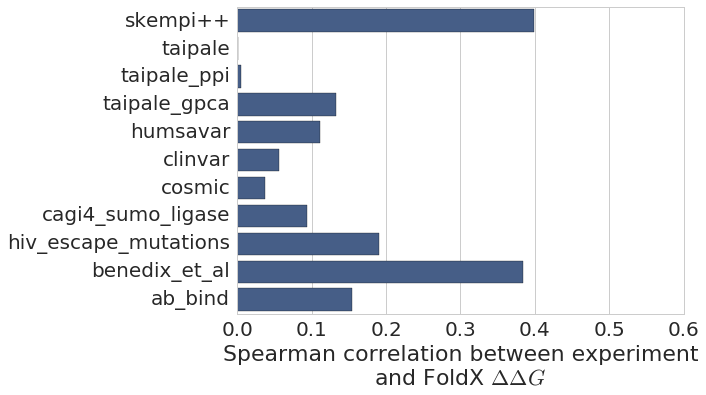

In [38]:
corrs = OrderedDict()
for table_name in datasets:
    df = DATA_DF[DATA_DF['dataset'] == table_name].drop_duplicates().copy()
    if table_name in ['humsavar', 'clinvar', 'cosmic']:
        df['ddg_exp'] = df['del_class_exp']
    if table_name in ['cagi4_sumo_ligase']:
        df['ddg_exp'] = -df['del_score_exp']
    df = df.dropna(subset=['dg_change', 'ddg_exp'])
    corrs[table_name] = sp.stats.spearmanr(df['dg_change'], df['ddg_exp'])[0]
corrs = pd.Series(corrs)

fg, ax = plt.subplots()
x = sns.barplot(corrs.values, corrs.index, ax=ax, color=sns.xkcd_rgb["denim blue"])
plt.xlim(0, 0.6)
ax.set_xlabel('Spearman correlation between experiment\nand FoldX $\Delta \Delta G$')
# plt.savefig(op.join(NOTEBOOK_NAME, 'foldx_correlation_final.png'), bbox_inches='tight', dpi=220)
# plt.savefig(op.join(NOTEBOOK_NAME, 'foldx_correlation_final.pdf'), bbox_inches='tight')

### Correlation with Provean

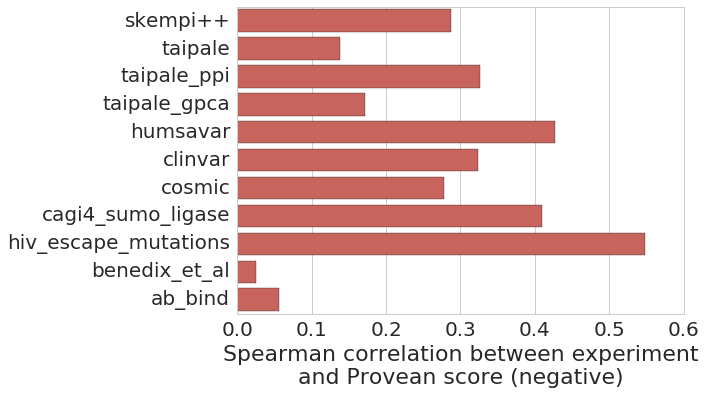

In [39]:
corrs = OrderedDict()
for table_name in datasets:
    df = DATA_DF[DATA_DF['dataset'] == table_name].drop_duplicates()
    if table_name in ['humsavar', 'clinvar', 'cosmic']:
        df['ddg_exp'] = df['del_class_exp']
    elif table_name in ['cagi4_sumo_ligase']:
        df['ddg_exp'] = -df['del_score_exp']
    df = df.dropna(subset=['provean_score', 'ddg_exp'])
    corrs[table_name] = -sp.stats.spearmanr(df['provean_score'], df['ddg_exp'])[0]
corrs = pd.Series(corrs)

fg, ax = plt.subplots()
x = sns.barplot(corrs.values, corrs.index, ax=ax, color=sns.xkcd_rgb["pale red"])
plt.xlim(0, 0.6)
ax.set_xlabel('Spearman correlation between experiment\nand Provean score (negative)')
# plt.savefig(op.join(NOTEBOOK_NAME, 'provean_correlation_final.png'), bbox_inches='tight', dpi=220)
# plt.savefig(op.join(NOTEBOOK_NAME, 'provean_correlation_final.pdf'), bbox_inches='tight')

# DATA_DF_TT

## Parameters

In [40]:
if CORE_OR_INTERFACE in [1, 'interface']:
    datasets = [
        'protherm++',
        'taipale',
        #
        'humsavar_train',
        'clinvar_train',
        'cosmic_train',
        #
        'humsavar_test',
        'clinvar_test',
        'cosmic_test',
        #
        'cagi4_sumo_ligase',
    ]

In [41]:
if CORE_OR_INTERFACE in [1, 'interface']:
    datasets = [
        'skempi++',
        'taipale',
        'taipale_ppi',
        'taipale_gpca',
        #
        'humsavar_train',
        'clinvar_train',
        'cosmic_train',
        #
        'humsavar_test',
        'clinvar_test',
        'cosmic_test',
        #
        'cagi4_sumo_ligase',
        'hiv_escape_mutations',
        'benedix_et_al',
        'ab_bind',
    ]

## Dataset overlap

In [42]:
def get_unique_id(df):
    _df = df[['uniprot_id', 'uniprot_mutation']].dropna()
    uniprot_mutation_set = set(_df['uniprot_id'].astype(str) + '.' + _df['uniprot_mutation'].astype(str))
    
    try:
        _df = df[['pdb_id', 'pdb_mutation']].dropna()
        pdb_mutation_set = set(_df['pdb_id'].astype(str) + '.' + _df['pdb_mutation'].astype(str))
    except KeyError:
        pdb_mutation_set = set()

    return uniprot_mutation_set, pdb_mutation_set

In [43]:
column_map = [
    ('protherm++', 'Protherm') if CORE_OR_INTERFACE == 0 else None,
    ('skempi++', 'Skempi') if CORE_OR_INTERFACE == 1 else None,
    ('taipale', 'Taipale'),
    ('taipale_ppi', 'Taipale PPI') if CORE_OR_INTERFACE == 1 else None,
    ('taipale_gpca', 'Taipale GPCA') if CORE_OR_INTERFACE == 1 else None,
    ('humsavar_train', 'Humsavar (Validation)'),
    ('clinvar_train', 'ClinVar (Validation)'),
    ('cosmic_train', 'COSMIC (Validation)'),
    ('humsavar_test', 'Humsavar (Test)'),
    ('clinvar_test', 'ClinVar (Test)'),
    ('cosmic_test', 'COSMIC (Test)'),
    ('cagi4_sumo_ligase', 'SUMO Ligase'),
    ('ab_bind', 'AB-Bind'),
    ('benedix_et_al', 'Benedix') if CORE_OR_INTERFACE == 1 else None,
]

COLUMN_MAP = OrderedDict([c for c in column_map if c is not None])

In [44]:
datasets = list(COLUMN_MAP.keys())

In [45]:
counts = {}
df = DATA_DF_TT.dropna(subset=['ddg']).copy()
# datasets = [c for c in datasets_bak if c in COLUMN_MAP or print("Skipping dataset '{}'...".format(c))]
df_out = pd.DataFrame(columns=datasets, index=datasets, dtype=float)
__, training_pdb_mutations = get_unique_id(df[df['dataset'] == 'skempi++'])

In [46]:
training_pdb_mutations

{'1r0r.I_Y20W',
 '1r0r.I_P14Y',
 '1cho.I_Y20G',
 '1cho.I_R21S',
 '1jrh.I_W82Y',
 '1r0r.I_G32L',
 '1a22.D26A',
 '1a22.P306A',
 '1a22.B_Q366A',
 '3sgb.I_E19H',
 '1r0r.I_E19M',
 '1h9d.B_L103A',
 '1r0r.Y20R',
 '3sgb.I_G32F',
 '1ppf.I_L18P',
 '1gc1.R59A',
 '1r0r.I_Y20R',
 '1r0r.I_P14K',
 '1xd3.K6A',
 '1iar.A_I5A',
 '1a4y.A_I459A',
 '1r0r.I_E19L',
 '1r0r.R21H',
 '2hrk.A_T127V',
 '1a4y.A_W263A',
 '3sgb.G32I',
 '1cho.I_E19I',
 '1gc1.C_S49A',
 '1bxi.A_L52A',
 '1cho.I_K13R',
 '1dfj.I_K316A',
 '1bxi.A_N24A',
 '1dqj.C_D101A',
 '2ajf.N479K',
 '1ppf.I_T17Q',
 '1a22.B_S302A',
 '1cho.I_Y20R',
 '1cho.I_A15N',
 '3sgb.Y20P',
 '3sgb.I_E19S',
 '1eaw.N95A',
 '1ffw.B_C213A',
 '1a4y.B_R5A',
 '2pcc.D34A',
 '1brs.A_E73A',
 '3sgb.I_R21A',
 '1dan.U_V207A',
 '3sgb.I_L18P',
 '3sgb.T17M',
 '1r0r.N36T',
 '1dan.T_Q37A',
 '1jrh.L_W92A',
 '1gcq.P657A',
 '1r0r.L18W',
 '1a22.B_I303A',
 '1r0r.P14K',
 '1r0r.Y20P',
 '3sgb.I_P14E',
 '1r0r.I_T17F',
 '3bp8.C_A63F',
 '1a22.P59A',
 '1a22.C308A',
 '1r0r.G32I',
 '1r0r.K13Y',
 '2wpt

In [47]:
for dataset_1 in datasets:
    print(dataset_1)
    df_1 = df[df['dataset'] == dataset_1]
    if df_1.empty:
        print(dataset_1)
    if dataset_1 in ['ab_bind', 'benedix_et_al']:
        df_1['pdb_unique_id'] = df_1['pdb_id'] + '.' + df_1['pdb_mutation']
        _before = df_1.shape[0]
        df_1 = df_1[~df_1['pdb_unique_id'].isin(training_pdb_mutations)]
        print("Lost {} rows for dataset_1 {}".format(_before - df_1.shape[0], dataset_1))
    uniprot_mutation_set_1, pdb_mutation_set_1 = get_unique_id(df_1)
    counts[dataset_1] = max([len(uniprot_mutation_set_1), len(pdb_mutation_set_1)])
    for dataset_2 in datasets:
        # print('\t', dataset_2)
        df_2 = df[df['dataset'] == dataset_2]
        if df_2.empty:
            print(dataset_2)
        if dataset_2 in ['ab_bind', 'benedix_et_al']:
            df_2['pdb_unique_id'] = df_2['pdb_id'] + '.' + df_2['pdb_mutation']
            _before = df_2.shape[0]
            df_2 = df_2[~df_2['pdb_unique_id'].isin(training_pdb_mutations)]
            print("Lost {} rows for dataset_2 {}".format(_before - df_2.shape[0], dataset_2))
        uniprot_mutation_set_2, pdb_mutation_set_2 = get_unique_id(df_2)
        if uniprot_mutation_set_1:
            uniprot_frac_covered = (
                1 - len(uniprot_mutation_set_1 - uniprot_mutation_set_2) / len(uniprot_mutation_set_1))
        else:
            uniprot_frac_covered = 0
        if pdb_mutation_set_1:
            pdb_frac_covered = (
                1 - len(pdb_mutation_set_1 - pdb_mutation_set_2) / len(pdb_mutation_set_1))
        else:
            pdb_frac_covered = 0
        df_out.loc[dataset_1, dataset_2] = max([uniprot_frac_covered, pdb_frac_covered]) * 100.0

df_out.columns = [COLUMN_MAP[c] for c in df_out.columns]
df_out.index = ['{}\n(n = {:,.0f})'.format(COLUMN_MAP[c], counts[c]) for c in df_out.index]

skempi++
Lost 86 rows for dataset_2 ab_bind
Lost 76 rows for dataset_2 benedix_et_al
taipale
Lost 86 rows for dataset_2 ab_bind
Lost 76 rows for dataset_2 benedix_et_al
taipale_ppi
Lost 86 rows for dataset_2 ab_bind
Lost 76 rows for dataset_2 benedix_et_al
taipale_gpca
Lost 86 rows for dataset_2 ab_bind
Lost 76 rows for dataset_2 benedix_et_al
humsavar_train
Lost 86 rows for dataset_2 ab_bind
Lost 76 rows for dataset_2 benedix_et_al
clinvar_train
Lost 86 rows for dataset_2 ab_bind
Lost 76 rows for dataset_2 benedix_et_al
cosmic_train
Lost 86 rows for dataset_2 ab_bind
Lost 76 rows for dataset_2 benedix_et_al
humsavar_test
Lost 86 rows for dataset_2 ab_bind
Lost 76 rows for dataset_2 benedix_et_al
clinvar_test
Lost 86 rows for dataset_2 ab_bind
Lost 76 rows for dataset_2 benedix_et_al
cosmic_test
Lost 86 rows for dataset_2 ab_bind
Lost 76 rows for dataset_2 benedix_et_al
cagi4_sumo_ligase
Lost 86 rows for dataset_2 ab_bind
Lost 76 rows for dataset_2 benedix_et_al
ab_bind
Lost 86 rows fo

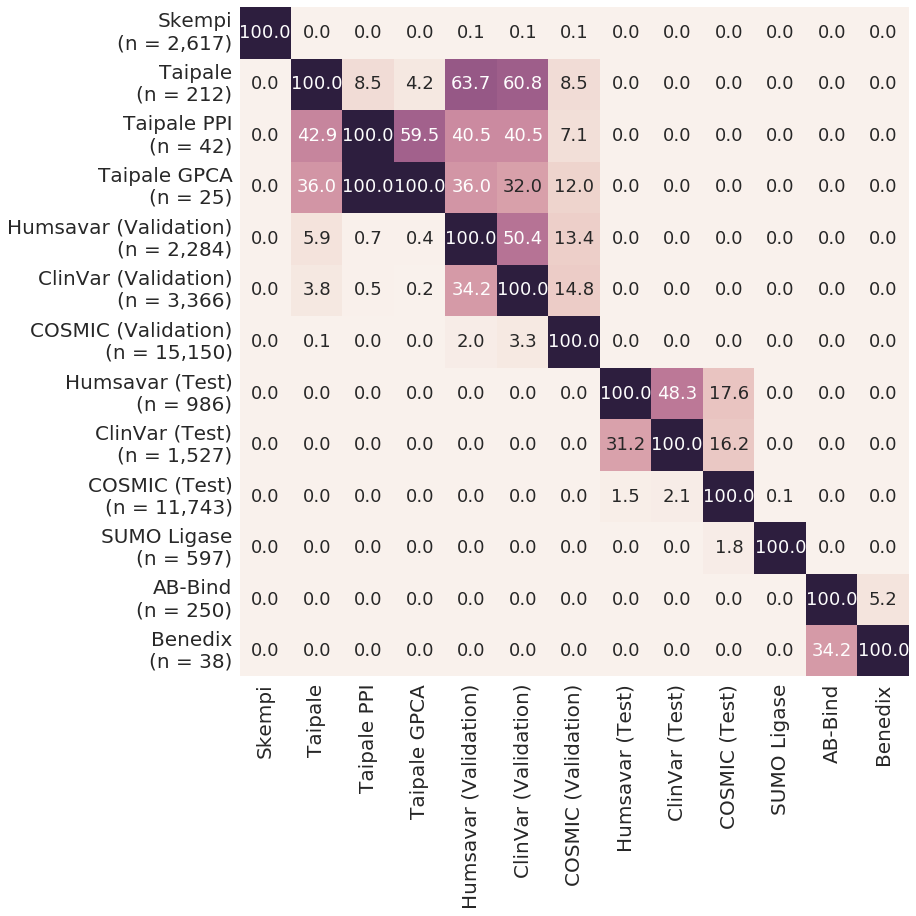

In [48]:
fg, ax = plt.subplots(figsize=(14, 12))
sns.heatmap(df_out, annot=True, fmt=".1f", ax=ax, square=True, cbar=False, annot_kws={"size": 18})
plt.yticks(rotation='horizontal')
# plt.xticks(rotation=45)
plt.savefig(
    op.join(NOTEBOOK_NAME, 'training_set_overlap_data_df_tt{}.png'.format(COI_SUFFIX.lower())), 
    bbox_inches='tight', dpi=220)
plt.savefig(
    op.join(NOTEBOOK_NAME, 'training_set_overlap_data_df_tt{}.pdf'.format(COI_SUFFIX.lower())),
    bbox_inches='tight')

## Correlations

### Correlation with FoldX

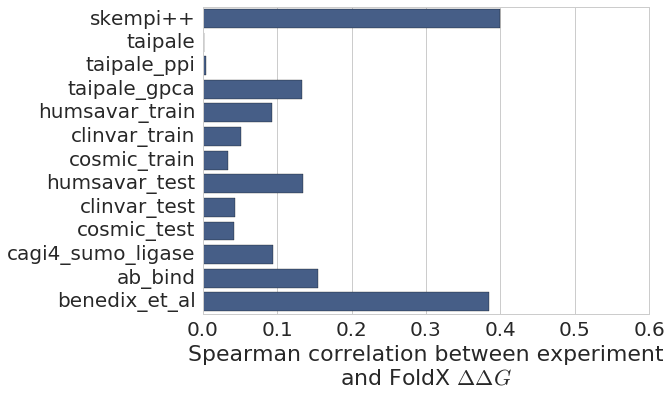

In [49]:
corrs = OrderedDict()
for table_name in datasets:
    df = DATA_DF_TT[DATA_DF_TT['dataset'] == table_name].drop_duplicates().copy()
    if table_name in [
            'humsavar_train', 'clinvar_train', 'cosmic_train', 
            'humsavar_test', 'clinvar_test', 'cosmic_test']:
        df['ddg_exp'] = df['del_class_exp']
    if table_name in ['cagi4_sumo_ligase']:
        df['ddg_exp'] = -df['del_score_exp']
    df = df.dropna(subset=['dg_change', 'ddg_exp'])
    corrs[table_name] = sp.stats.spearmanr(df['dg_change'], df['ddg_exp'])[0]
corrs = pd.Series(corrs)

fg, ax = plt.subplots()
x = sns.barplot(corrs.values, corrs.index, ax=ax, color=sns.xkcd_rgb["denim blue"])
plt.xlim(0, 0.6)
ax.set_xlabel('Spearman correlation between experiment\nand FoldX $\Delta \Delta G$')
# plt.savefig(op.join(NOTEBOOK_NAME, 'foldx_correlation_final.png'), bbox_inches='tight', dpi=220)
# plt.savefig(op.join(NOTEBOOK_NAME, 'foldx_correlation_final.pdf'), bbox_inches='tight')

### Correlation with Provean

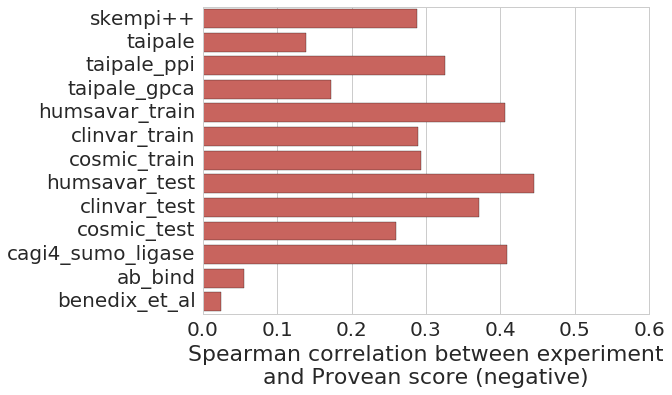

In [50]:
corrs = OrderedDict()
for table_name in datasets:
    df = DATA_DF_TT[DATA_DF_TT['dataset'] == table_name].drop_duplicates()
    if table_name in [
            'humsavar_train', 'clinvar_train', 'cosmic_train', 
            'humsavar_test', 'clinvar_test', 'cosmic_test']:
        df['ddg_exp'] = df['del_class_exp']
    if table_name in ['cagi4_sumo_ligase']:
        df['ddg_exp'] = -df['del_score_exp']
    df = df.dropna(subset=['provean_score', 'ddg_exp'])
    corrs[table_name] = -sp.stats.spearmanr(df['provean_score'], df['ddg_exp'])[0]
corrs = pd.Series(corrs)

fg, ax = plt.subplots()
x = sns.barplot(corrs.values, corrs.index, ax=ax, color=sns.xkcd_rgb["pale red"])
plt.xlim(0, 0.6)
ax.set_xlabel('Spearman correlation between experiment\nand Provean score (negative)')
# plt.savefig(op.join(NOTEBOOK_NAME, 'provean_correlation_final.png'), bbox_inches='tight', dpi=220)
# plt.savefig(op.join(NOTEBOOK_NAME, 'provean_correlation_final.pdf'), bbox_inches='tight')

In [51]:
train_datasets = [
    'protherm++', 'taipale', 'humsavar_train', 'clinvar_train', 'cosmic_train', 'cagi4_sumo_ligase'
]

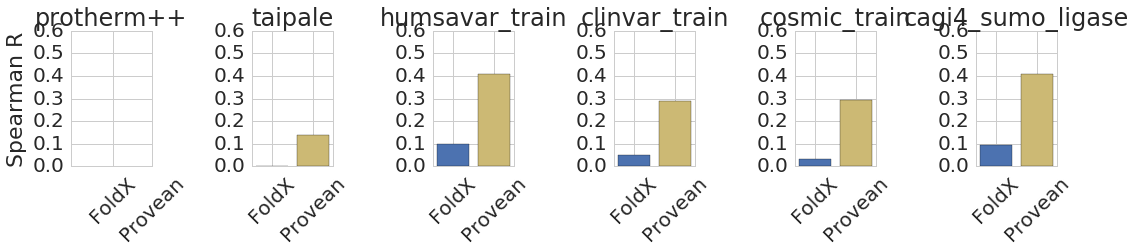

In [52]:
# Compare ELASPIC and FoldX on the test set (NO ABS)
fg, axes = plt.subplots(1, 6, figsize=(16, 4))
axes[0].set_ylabel('Spearman R')
for i, train_dataset in enumerate(train_datasets):
    ax = axes[i]
    # print(train_dataset)
    if train_dataset in ['protherm++', 'taipale']:
        df = (
            DATA_DF_TT[DATA_DF_TT['dataset'] == train_dataset]
            [['dg_change', 'ddg_exp', 'provean_score']]
            .dropna()
        )
        foldx_r = sp.stats.spearmanr(df['dg_change'], df['ddg_exp'])[0]
        provean_r = sp.stats.spearmanr(df['provean_score'], df['ddg_exp'])[0] * -1
    elif train_dataset in ['cagi4_sumo_ligase']:
        df = (
            DATA_DF_TT[DATA_DF_TT['dataset'] == train_dataset]
            [['dg_change', 'del_score_exp', 'provean_score']]
            .dropna()
        )
        foldx_r = sp.stats.spearmanr(df['dg_change'], -df['del_score_exp'])[0]
        provean_r = sp.stats.spearmanr(df['provean_score'], -df['del_score_exp'])[0] * -1
    else:
        df = (
            DATA_DF_TT[DATA_DF_TT['dataset'] == train_dataset]
            [['dg_change', 'del_class_exp', 'provean_score']]
            .dropna()
        )
        foldx_r = sp.stats.spearmanr(df['dg_change'], df['del_class_exp'])[0]
        provean_r = sp.stats.spearmanr(df['provean_score'], df['del_class_exp'])[0] * -1
    ax.bar(
        [1, 2], 
        [abs(foldx_r), abs(provean_r)],
        tick_label=['FoldX', 'Provean'], 
        align='center', 
        color=[sns.palettes.color_palette()[0], 
               sns.palettes.color_palette()[4]])
    ax.set_ylim(0, 0.60)
    ax.set_title(train_dataset)
    ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=45)
    # print(elaspic_r, foldx_r)

plt.tight_layout()

# plt.savefig(op.join(NOTEBOOK_NAME, 'initial_performance.png'), bbox_inches='tight', dpi=220)
# plt.savefig(op.join(NOTEBOOK_NAME, 'initial_performance.pdf'), bbox_inches='tight')

In [53]:
test_datasets = [
    'protherm++', 'taipale', 'humsavar_test', 'clinvar_test', 'cosmic_test', 'cagi4_sumo_ligase'
]

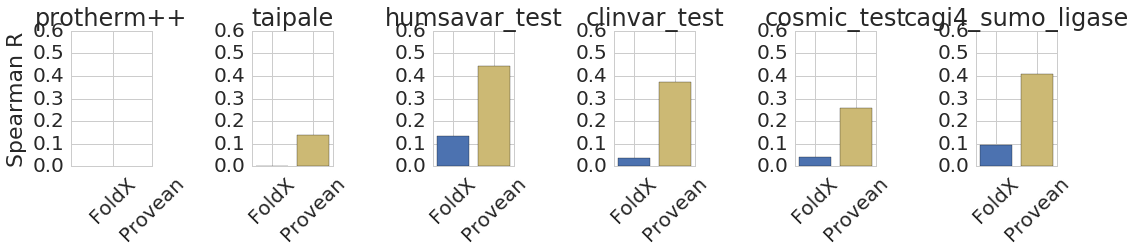

In [54]:
# Compare ELASPIC and FoldX on the test set (NO ABS)
fg, axes = plt.subplots(1, 6, figsize=(16, 4))
axes[0].set_ylabel('Spearman R')
for i, test_dataset in enumerate(test_datasets):
    ax = axes[i]
    # print(test_dataset)
    if test_dataset in ['protherm++', 'taipale']:
        df = (
            DATA_DF_TT[DATA_DF_TT['dataset'] == test_dataset]
            [['dg_change', 'ddg_exp', 'provean_score']]
            .dropna()
        )
        foldx_r = sp.stats.spearmanr(df['dg_change'], df['ddg_exp'])[0]
        provean_r = sp.stats.spearmanr(df['provean_score'], df['ddg_exp'])[0] * -1
    elif test_dataset in ['cagi4_sumo_ligase']:
        df = (
            DATA_DF_TT[DATA_DF_TT['dataset'] == test_dataset]
            [['dg_change', 'del_score_exp', 'provean_score']]
            .dropna()
        )
        foldx_r = sp.stats.spearmanr(df['dg_change'], -df['del_score_exp'])[0]
        provean_r = sp.stats.spearmanr(df['provean_score'], -df['del_score_exp'])[0] * -1
    else:
        df = (
            DATA_DF_TT[DATA_DF_TT['dataset'] == test_dataset]
            [['dg_change', 'del_class_exp', 'provean_score']]
            .dropna()
        )
        foldx_r = sp.stats.spearmanr(df['dg_change'], df['del_class_exp'])[0]
        provean_r = sp.stats.spearmanr(df['provean_score'], df['del_class_exp'])[0] * -1
    ax.bar(
        [1, 2], 
        [abs(foldx_r), abs(provean_r)],
        tick_label=['FoldX', 'Provean'], 
        align='center', 
        color=[sns.palettes.color_palette()[0], 
               sns.palettes.color_palette()[4]])
    ax.set_ylim(0, 0.60)
    ax.set_title(test_dataset)
    ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=45)
    # print(elaspic_r, foldx_r)

plt.tight_layout()

# plt.savefig(op.join(NOTEBOOK_NAME, 'initial_performance.png'), bbox_inches='tight', dpi=220)
# plt.savefig(op.join(NOTEBOOK_NAME, 'initial_performance.pdf'), bbox_inches='tight')

# Done

In [55]:
print(datetime.datetime.now())

2016-09-20 23:37:21.489279
